In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

DATA_PATH = "./poem_data"

# Poetic forms as listed in The Making of a Poem, A Norton Anthology of Poetic Forms
norton_forms = ['villanelle', 'sestina', 'pantoum', 'sonnet', 'ballad', 'blank-verse', 'heroic-couplet', 'stanza', 'elegy', 'pastoral', 'ode']

In [5]:
# Load txt files
def load_data(path_to_data, directory):
    labels = []
    text = []
    author = []
    title = []

    path_to_data = os.path.join(path_to_data, directory)
    folders = sorted(os.listdir(path_to_data))
    if '.DS_Store' in folders: 
        folders.remove('.DS_Store')
    for folder in folders:
        folder_path = os.path.join(path_to_data, folder)
        for file in os.listdir(folder_path):
            if file == '.DS_Store': 
                continue
            file_path = os.path.join(folder_path, file)
            # pull text from file
            with open(file_path, "r") as f:
                try:
                    content = f.readlines()
                except UnicodeDecodeError: 
                    print(file_path)
                content = ''.join(content)
            text.append(content)           
            # clean filename for title and author
            if folder.find("-") == -1:
                cut_index = len(folder + "Poems")
            else: 
                cut_index = len(folder + "Poems") - 1
            file = file[cut_index:].rstrip(".txt").split("Poemby", 1)
            title_list = [s for s in re.split("([A-Z][^A-Z]*)", file[0]) if s]
            author_list = [s for s in re.split("([A-Z][^A-Z]*)", file[1]) if s]
            title.append(" ".join(title_list))
            author.append(" ".join(author_list))
            # add form of poem
            labels.append(folder)
        
    df = pd.DataFrame(list(zip(author, title)), columns=['author', 'poem_title'])
    df = df.assign(poem_text=text)
    if directory == 'forms':
        df = df.assign(form=labels)
    else:
        df = df.assign(tags=labels)
    df = df.assign(collected_from="Poem Hunter")
    df = df.assign(poem_link="unknown")
    return df

In [6]:
# Load poem foundation dataset (https://github.com/maria-antoniak/poetry-eval/blob/main/data/poetry-evaluation_public-domain-poems.csv)
foundation_poems = pd.read_csv(os.path.join(DATA_PATH, "poetry-evaluation_public-domain-poems.csv"))
foundation_poems = foundation_poems.loc[:, ['author', 'poem_title', 'poem_text', 'form', 'tags', 'poem_link', 'collected_from']]
foundation_poems.rename(columns={"tags": "topics"}, inplace=True)
print(f"Number of poems from Poem Foundation and Academy of American Poets: {foundation_poems.shape[0]}")

# Load poem hunter dataset (https://www.kaggle.com/datasets/michaelarman/poemsdataset/data?select=forms)
hunter_poems_forms = load_data(DATA_PATH, "forms")
hunter_poems_topics = load_data(DATA_PATH, "topics")

# Get topic if provided
topics = hunter_poems_topics[hunter_poems_topics['poem_title'].isin(hunter_poems_forms['poem_title'])]
zipped_tags = zip(topics['poem_title'], topics['tags'])
mapping = dict(zipped_tags)
hunter_poems_forms['topics'] = hunter_poems_forms['poem_title'].map(mapping)
hunter_poems_forms.fillna({'topics': 'unknown'}, inplace=True)

# Move "collected_from" column to end
hunter_poems_forms = hunter_poems_forms.reindex(columns=['author', 'poem_title', 'poem_text', 'form', 'topics', 'poem_link', 'collected_from'])
print(f"Number of poems from Poem Hunter: {hunter_poems_forms.shape[0]}")
      
# Load extracted Poetry Foundation poems
collected_poems = pd.read_csv(os.path.join(DATA_PATH, "collected_poems.csv"), sep='|')
print(f"Number of poems from scraped Poem Foundation: {collected_poems.shape[0]}")

# combine datasets
poems_df = pd.concat([foundation_poems, hunter_poems_forms, collected_poems], ignore_index=True)
poems_df['poem_text'] = poems_df['poem_text'].str.strip()

# Remove non-English poems
poems_df = poems_df[~poems_df['author'].isin(['Christopher Tye', 'Francie Lynch', 'C P Sharma','Luo Zhihai', 'Joachimdu Bellay', 'Honoréd Urfé'])]

# drop duplicates
poems_df = poems_df.drop_duplicates(subset=['author', 'poem_title']).reset_index(drop=True) 
poems_df = poems_df.drop_duplicates(subset=['poem_text']).reset_index(drop=True) 
poems_df.describe() 


Number of poems from Poem Foundation and Academy of American Poets: 1453
Number of poems from Poem Hunter: 6297
Number of poems from scraped Poem Foundation: 2387


,author,poem_title,poem_text,form,topics,poem_link,collected_from
count,9124,9152,9152,9152,9152,9152,9152
unique,2370,8649,9152,147,2849,3011,5
top,Muzahidul Reza,Aubade,Here bygynneth the Book of the tales of Caunte...,sonnet,unknown,unknown,Poem Hunter
freq,925,40,1,1012,5884,6081,6081


form
sonnet             1012
couplet             713
free-verse          382
pastoral            235
ballad              218
                   ... 
occasional-poem       2
divino-sonetto        2
pindaric-ode          2
irregular-ode         1
triversen             1
Name: count, Length: 141, dtype: int64


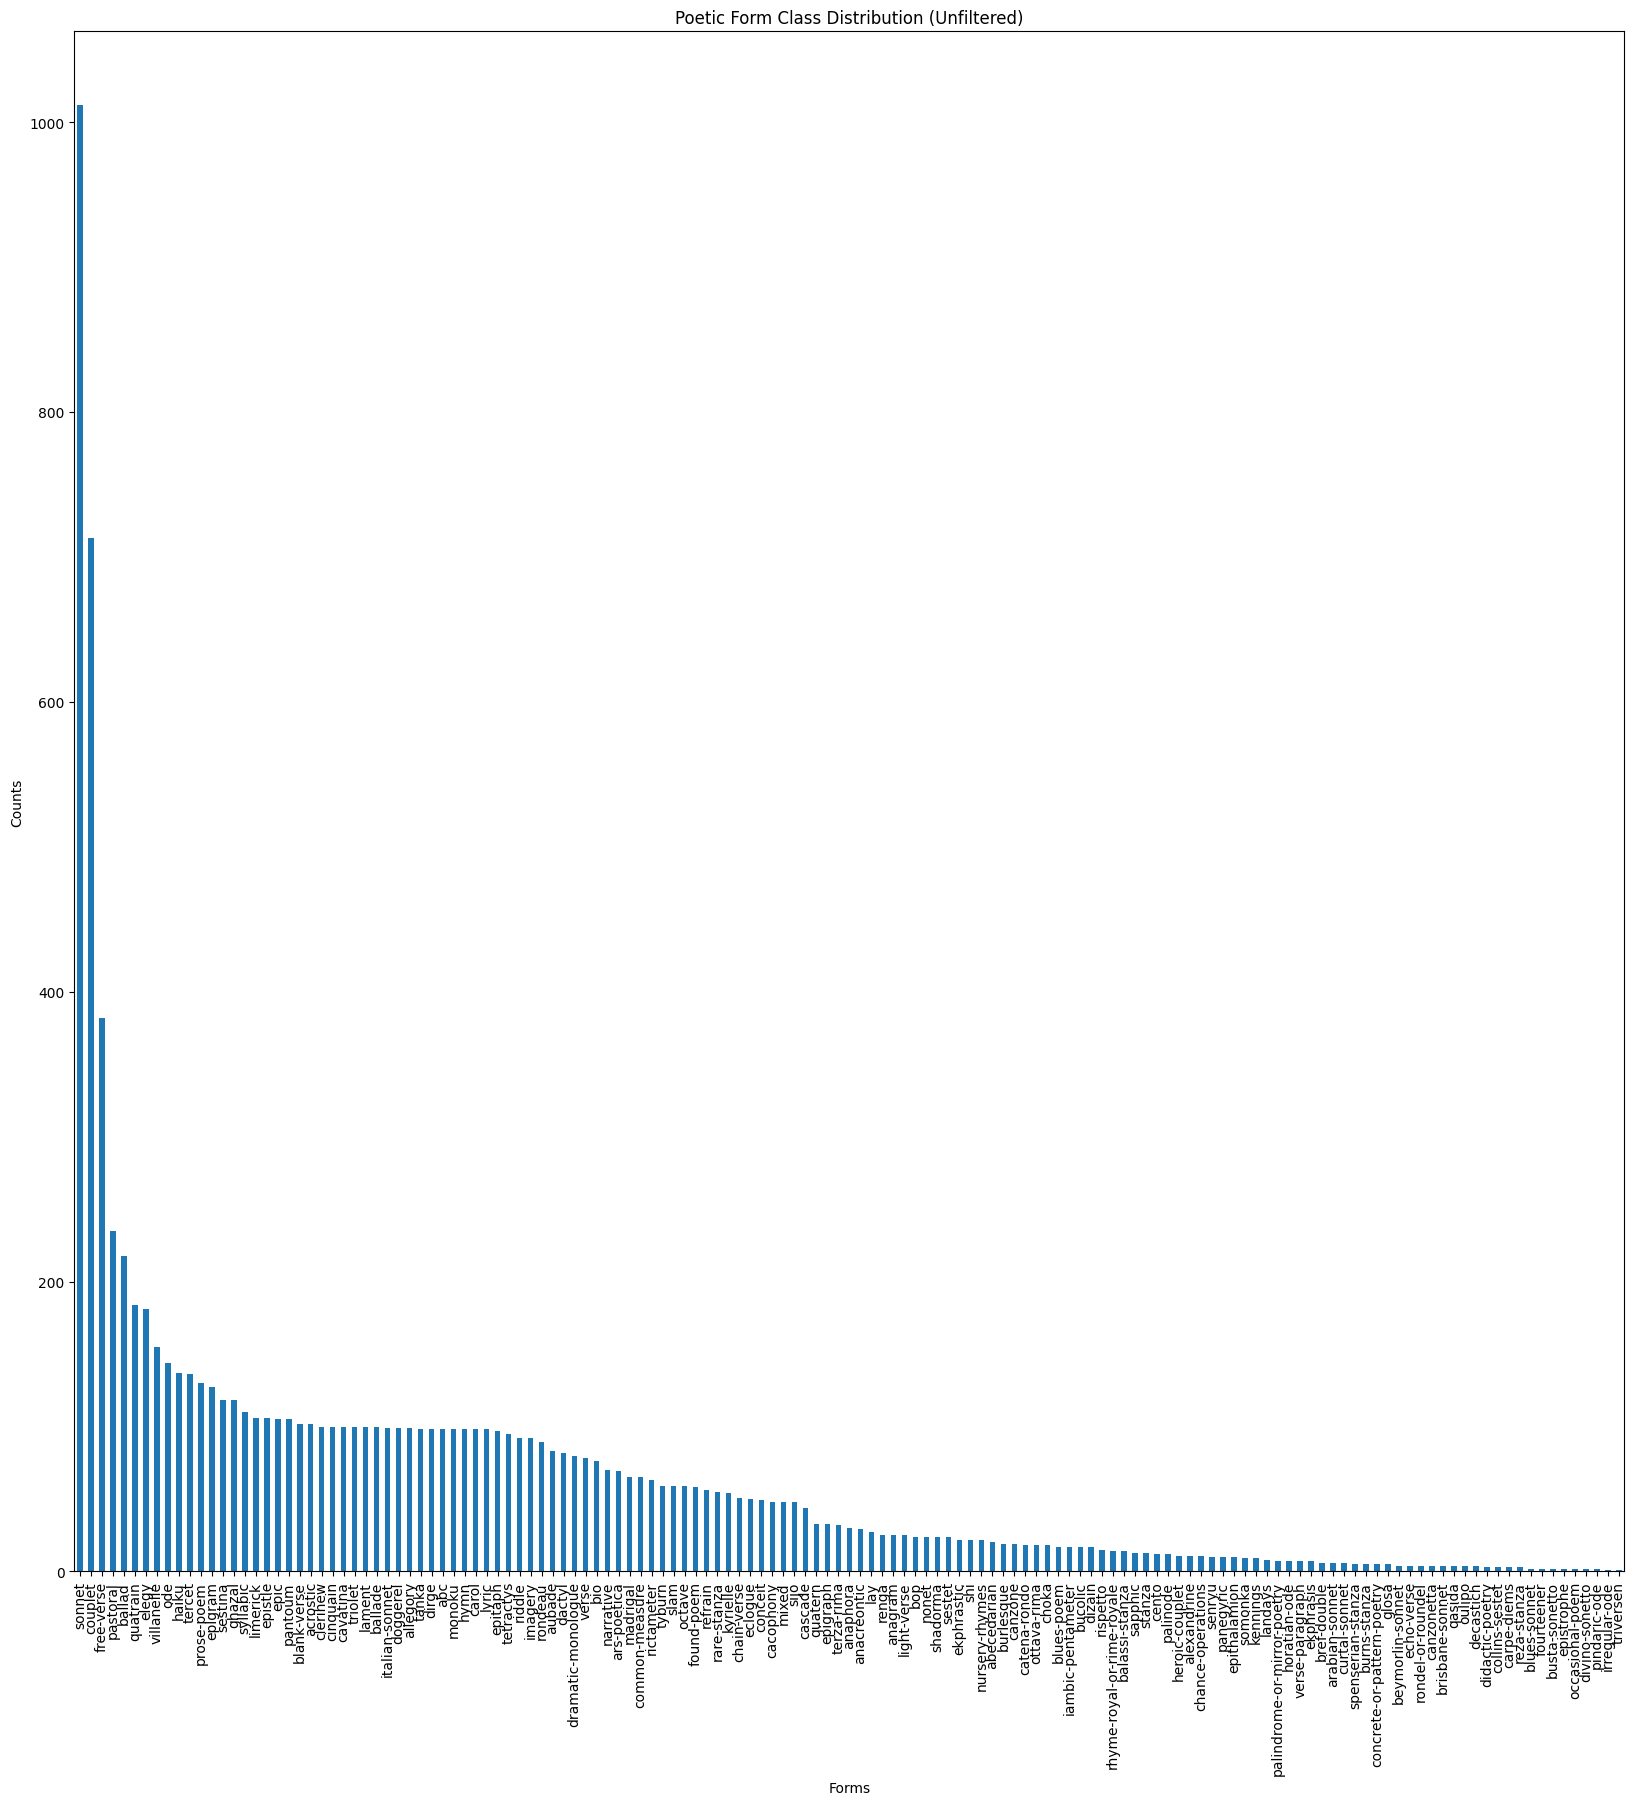

In [7]:
# Combine repeated form types
poems_df.loc[poems_df['form'] == 'blank verse', 'form'] = 'blank-verse'
poems_df.loc[poems_df['form'] == 'dramatic monologue', 'form'] = 'dramatic-monologue'
poems_df.loc[poems_df['form'] == 'ars poetica', 'form'] = 'ars-poetica'
poems_df.loc[poems_df['form'] == 'concrete or pattern poetry', 'form'] = 'concrete-or-pattern-poetry'
poems_df.loc[poems_df['form'] == 'common measure', 'form'] = 'common-measure'
poems_df.loc[poems_df['form'] == 'syllabic-verse', 'form'] = 'syllabic'
poems_df.loc[poems_df['form'] == 'prose poem', 'form'] = 'prose-poem'
poems_df.loc[poems_df['form'] == 'free verse', 'form'] = 'free-verse'

# Find form counts
form_counts = poems_df['form'].value_counts()
print(form_counts)
# Plot the counts
plt.figure(figsize = (20, 20))
form_counts.plot(kind='bar')
plt.xlabel('Forms')
plt.ylabel('Counts')
plt.title("Poetic Form Class Distribution (Unfiltered)")
plt.show()


In [8]:
# Select only Norton poetic forms
poems_df = poems_df.loc[poems_df['form'].isin(norton_forms)]

In [9]:
extra_characters = ['@', '©', 'Reference:', 'Poet\'s note:', 'Submitted by', 'Translated from', 'Translated by', 'Written:', 'Written January', 'published in', 'Published by', 'published by', 'Published online', 'published online', 'Copyright', 'Wisconsin', '2009', '2008', '2005', '2010', '2014', 'All rights reserved', 'All Rights Reserved', 'Winner 2', 'Anonymous Submission']

def get_extra_df():
    extra_df = pd.DataFrame()
    for item in extra_characters:     
        hunter = poems_df.loc[poems_df['collected_from'] == "Poem Hunter"]
        extra_df[item] = poems_df.loc[:, 'poem_text'].str.contains(item)
    return hunter.loc[extra_df[extra_characters].any(axis=1)  == True]

extra_words_df = get_extra_df()

while len(extra_words_df) > 0:
    has_extra_lines = poems_df[poems_df.index.isin(extra_words_df.index)]
    has_extra_lines.loc[:, 'poem_text'] = has_extra_lines['poem_text'].str.rsplit('\n', n=1).str[0]
    zipped = zip(has_extra_lines.index, has_extra_lines['poem_text'])
    mapping = dict(zipped)
    poems_df['updated_text'] = poems_df.index.map(mapping)
    poems_df['poem_text'] = np.where(poems_df['updated_text'].notna(), poems_df['updated_text'], poems_df['poem_text'])
    poems_df.drop('updated_text', axis=1, inplace=True)
    extra_words_df = get_extra_df()

poems_df.describe()

,author,poem_title,poem_text,form,topics,poem_link,collected_from
count,2283,2294,2294,2294,2294,2294,2294
unique,803,2192,2294,11,1287,1456,5
top,William Shakespeare,Pastoral,I’d sing of Love in such a novel fashion\nthat...,sonnet,unknown,unknown,Poem Hunter
freq,215,13,1,1012,731,800,800


In [10]:
# Find form counts
form_counts = poems_df['form'].value_counts()
print(form_counts)

form
sonnet            1012
pastoral           235
ballad             218
elegy              181
villanelle         155
ode                144
sestina            118
pantoum            105
blank-verse        102
stanza              13
heroic-couplet      11
Name: count, dtype: int64


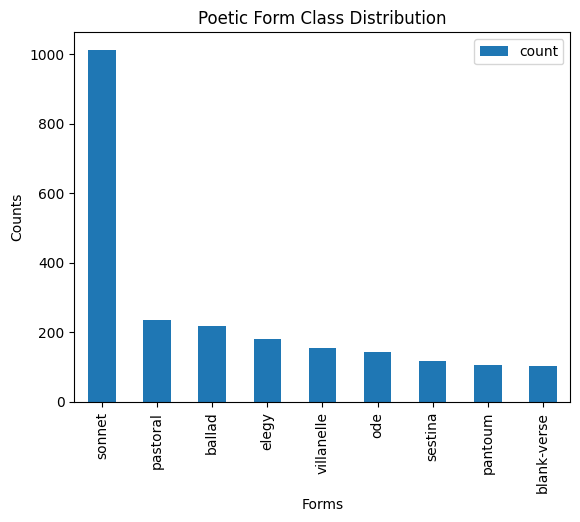

In [11]:
poems_df = poems_df.loc[~poems_df['form'].isin(['stanza', 'heroic-couplet'])]

# Find form counts
form_counts = poems_df['form'].value_counts().to_frame()

# Plot the counts
form_counts.plot(kind='bar')
plt.xlabel('Forms')
plt.ylabel('Counts')
plt.title("Poetic Form Class Distribution")
plt.show()



In [12]:
# Randomly shuffle dataframe
poems_df = poems_df.sample(frac=1)

# Save cleaned data to csv
poems_df.to_csv('./data/poems_clean.csv', index=False)
poems_df.describe()

,author,poem_title,poem_text,form,topics,poem_link,collected_from
count,2259,2270,2270,2270,2270,2270,2270
unique,802,2168,2270,9,1287,1456,5
top,William Shakespeare,Pastoral,"I\n\nImmense, august, like some Titanic bloom,...",sonnet,unknown,unknown,Poem Hunter
freq,215,13,1,1012,707,776,776
